# Decluttering


### Purpose

This notebook attempts to find potential clutter in the organisation, and send a gentle reminder to the item owners to consider removing the items. 

### Introduction

A good sign of a healthy ArcGIS System is the velocity of new items being created and shared amongst the users.  And creating collaborative content is something that should be encouraged.  However, a knock-on effect with this is that your ArcGIS System can start to accumulate older content that may no longer be useful to the organisation.  

It can be a good idea to run scheduled stocktakes to ensure the content is still being used and relevant. 

Some people hoarde.  They like to accumulate items regardless of if they still have any value or use within the greater organisation.  As long as this content is shared appropriately (i.e. kept private to the user), then this is not a huge issue.  However, content uses storage and this can lead to either credits or infrastructure costs.

Some hoarders (myself included) may just be unaware of the items they have accumulated and are no longer being used.  

As an ArcGIS System owner, it is considerate to not force decluttering your users content.  But a polite nudge might be all that is needed to challenge the item owners to consider removing their items.

As an ArcGIS System owner, this notebook will help you filter down your organisations content to report on the clutter, and allow you to notify the item owners about this content.  

The notebook can be run ad-hoc or scheduled to run, perhaps once a month.

## Finding the Content

#### Connect to GIS
The Principle of Least Privilege requires that this Notebook should connect to the GIS with the following admin privilege(s):

- Allow member to view all content within your organization.

Running a notebook with full admin privileges is high risk, especially if you start to modify the notebook.  Copy this notebook into an ArcGIS Developer Plan to customise and familiarise yourself before running against a production system.


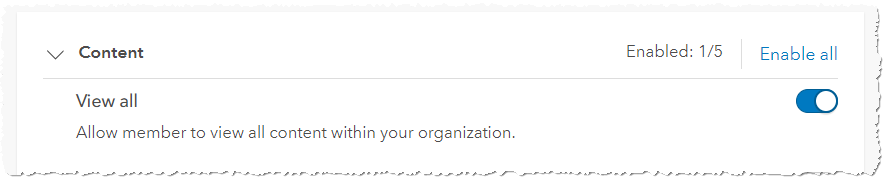

In [ ]:
from arcgis.gis import GIS
gis = GIS("home", expiration=9999)
#gis = GIS("https://esriau.maps.arcgis.com/","","", expiration=9999)

#### Set your thresholds

Defining clutter will have mixed opinions. To attempt to quantify it, we can use three variables:

1. Has this item had any significant usage recently?

2. How much disk space does this item take up?

3. How old is the item?

In [2]:
# Items with less than {views} in last 60 days
views = 20 
# Items greater than {size_mb} in filesize
size_mb = 10 
#Items older than {age_days} 
age_days = 60

# Table Item in ArcGIS Online to report on clutter items
table_item = '360d491480684a6da51ecee57ab166a7' # PROD
#table_item = '811047de84514a14a4a38080570889d9'  # TEST

#### Find the Clutter

Filter to just the hosted feature item types, as these use up the most credits.

This can be removed from filter if you want to search across all items.

For testing you can also add a *query="owner:user"* to just look at an individuals content.

Should use a query to filter out items older than *age_days*, but encountered an issue, so filtering these out a few cells later.

In [3]:
# Find all Hosted Feature Services
# Can switch to using advanced_search for portal with more than 10k items.  
all_items = gis.content.search(query="*", sort_field="modified", sort_order="desc", item_type="Feature Service", max_items = 9999)
print("#FS Items found using search: " + str(len(all_items))) 

#FS Items found using search: 4079


The following cell:

- Iterates through the items from above query
- Filter list to large items (threshold set by *size_mb*)
- Fetch the usage data on each item (# views in last 60 days)
- Filter list to low usage items (threshold set in *views*)
- Get some reporting metrics for each item
- Get additional reporting metrics from the item.owner

This cell can take awhile to run, depending on how many items you have in your organisation.

Some items it can have issue with.  This includes table services and feature servcices from other unfederated sites/orgs.

In [ ]:
f_item = []

from datetime import datetime
for i in all_items:
    
    # Create an empty dictionary for each item
    f = {"attributes":{}}
    
    # Check if old item.  Is item created more than {age_days} ago? 
    i_created_time = datetime.fromtimestamp(round(i.created / 1000))
    # print(f"Item Created: {i_created_time}")
    date_diff = datetime.utcnow() - i_created_time
    
    if date_diff.days < age_days:
        print(f"{i.title} is NOT older than {age_days} days")
        continue
    
    # Filter to the large filesize items
    if i.size/1024/1024 > size_mb:       
        # Calculate #Views in last 60 days
        try:
            df_u = i.usage ('60D', as_df=True)
            total_usage_60d = df_u['Usage'].sum()
        except:
            print("Issue with Item: " + i.title + ", skipping to next item")
        
        # Filter to the items with low usage over last 60 days
        if total_usage_60d < views:  # threshold set in an earlier cell
            
            f['attributes']['title'] = i['title']
            f['attributes']['id'] = i['id']
            f['attributes']['owner'] = i['owner']
            f['attributes']['created'] = i['created']
            f['attributes']['modified'] = i['modified']
            f['attributes']['type'] = i['type']
            f['attributes']['url'] = i.homepage
            f['attributes']['access'] = i['access']
            f['attributes']['scoreCompleteness'] = i['scoreCompleteness']
            f['attributes']['size_mb'] = i.size/1000000
            f['attributes']['numViews60d'] = total_usage_60d
            f['attributes']['numViews'] = i['numViews']
            f['attributes']['CreditsMonth'] = ((i.size/1000000)/10)*2.4
            
            # Go get item.owner details
            try:
                user = gis.users.get(username= i.owner)
                f['attributes']['FirstName'] = user.firstName
                f['attributes']['email'] = user.email
                f['attributes']['disabled'] = user.disabled
                #f_item.append(f)
            except:
                #f_item.append(f)
                print("Issue getting owner for: " + i.title + ", skipping to next item")           

            f_item.append(f)
            
print("#FS Items that are stale: " + str(len(f_item)))             

Item Created: 2013-04-15 00:53:16
Item Created: 2013-04-22 03:52:44
Item Created: 2014-03-22 09:19:18
Item Created: 2014-05-02 02:33:27
Item Created: 2013-07-31 00:57:10
Item Created: 2014-03-22 09:16:24
Item Created: 2014-08-14 03:43:22
Item Created: 2014-08-15 05:22:08
Item Created: 2014-08-15 05:22:08
Item Created: 2014-08-15 05:22:08
Item Created: 2014-08-15 05:22:08
Item Created: 2014-08-15 05:22:09
Item Created: 2014-08-15 05:22:09
Item Created: 2014-08-15 05:22:09
Item Created: 2014-08-15 04:50:11
Item Created: 2014-08-15 05:19:59
Item Created: 2014-08-15 05:17:43
Item Created: 2014-08-15 05:22:08
Item Created: 2014-08-15 05:20:27
Item Created: 2014-08-15 05:20:28
Item Created: 2014-08-15 05:20:27
Item Created: 2014-08-15 05:20:27
Item Created: 2014-08-15 05:19:14
Item Created: 2014-08-20 10:46:37
Item Created: 2014-09-01 06:19:31
Item Created: 2014-09-02 05:41:34
Item Created: 2014-09-02 13:13:38
Item Created: 2014-09-11 04:27:35
Item Created: 2014-09-26 00:13:32
Item Created: 

### Write the results to a table

In [13]:
# delete existing records in table
dest_fl = gis.content.get(table_item).tables[0]
dest_fl.manager.truncate()

# Update the Hosted Table with the item details in chunks
n = 1000

for i in range(0, len(f_item), n):
    chunk = f_item[i:i+n]
    result = dest_fl.edit_features(adds=chunk)
    print(f'added items {i+1}-{i+n}...')

print(f"Finished writing {len(f_item)} items to table")

added items 1-1000...
Finished writing 3 items to table


<Item title:"Do we still want these (DEV LAYER)" type:Table Layer owner:jakc>
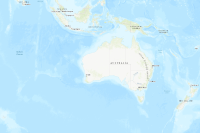

In [6]:
# Return table item
gis.content.get(table_item)

*TODO:  Return a dataframe of results here to view nicely, maybe not all fields?*

An idea, is to have this table showcased for your users to view and see.  

Knowing that there is an item shared with the organisation that lists out stale items will likely change the behaviour of your users to keep on top of cleaning up their own clutter.  

No-one wants to make it onto the table of large stale items!

## Notifying Users

There are various ways you can notify your users.  
- Send them an email
- Make a comment on their item
- Push a notification to them in the portal
- Push a message to another service such as Slack or a private Microsoft Teams message (via Microsoft Automate)

For this notebook, we are taking the approach of notifying the item owner through:
- commenting on the item (unless it is shared public/everyone)
- this sends them an email notification about the comment
- make sure we only send them one comment per item to avoid spamming them every time the notebook runs.


**Before running the below cells, make sure you are happy notifying your users about these items**

Optional, but we want to avoid making comments on public items for the world to see.  
The following cell filters the table down further to remove public items.  


In [60]:
stale_items = dest_fl.query(where="access <> 'public' ")
print(f"Non public items: {len(query_table)}")

Non public items: 4


Define a function that will check to see if this script has already notified these item owners before.

We only want to make one comment.  If they decide to ignore it, no problem.  We won't mention it again.


In [61]:
def check_comments(item):
    if not item.comments:
        #print(f"no comments on {item.title}, TRUE")
        return True
    else:
        comment_lst = []
        for c in item.comments:
            #print(c.get('comment')) 
            text = c.get('comment')
            if text.startswith("⚠️"):  
                #print('This comment is a prior notification, FALSE')
                comment_lst.append(False)
                #return False
            else:
                #print('This comment something else')
                comment_lst.append(True)
    
    # Any of the comments a prior notification?  If so, return false
    if False in comment_lst:
        return False
    else:
        return True

Look at the items and remove any with previous notification comments

In [62]:
remove_lst = []
for f in stale_items.features:
    item = gis.content.get(f.get_value('id'))
    print(f"Checking comments on {item.title}...")
    notify = check_comments(item)
    if not notify:
        # Build up a list of items to remove from featureset
        remove_lst.append(f)
    else:
        continue
            
# remove 'items' from featureset that have notification comments
for i in remove_lst:
    stale_items.features.remove(i)
    
print(f"Items to Notify: {len(stale_items)}")
#print(stale_items.df["title"])

# Add a notification comment to the items:

from datetime import datetime

# Exit if there are no items to notify
if len(stale_items) == 0:
    #print("No items to notify")
    raise SystemExit("Stop right there!")

for i in stale_items:
    # Fetch some values to use in comment
    item = gis.content.get(i.get_value('id'))
    size = round(i.get_value('size_mb'), 2)
    views_60d = i.get_value('numViews60d')
    first_name = i.get_value('FirstName')
    item.add_comment(f"⚠️ AUTOMATED NOTIFCATION: Hi {first_name}. This item is {size} MB and has had {views_60d} views in the last 60 days.  Please consider if you still need it and if it can be deleted or a copy made offline.  If you still need it, no need to worry, it won't be deleted.")
    # Update ReminderSent field to todays date
    dt_string = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    i.set_value(field_name = "ReminderSent", value = dt_string)
    results = dest_fl.edit_features(updates=stale_items)

print(f"{len(results)} items commented on")
print("FINISHED")

Checking comments on Brimbank_AP...
Checking comments on Sold...
Checking comments on Deep Creek...
Checking comments on Vessel Locations (ExactEarth)...
Items to Notify: 1
3 items commented on
FINISHED
